In [96]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For Sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
cd ../..

/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA


In [98]:
def generate_PMD_data(m=100, n_X=10, sigma=1, density=0.5, mean=0, seed=1):
    "Generates data matrix for PCMF."
    np.random.seed(seed)
    u_star = np.random.randn(m) / 3.0
    v_star = np.random.randn(n_X) / 3.0
    X = np.random.normal(mean,sigma,size=((m,n_X))) / 3.0
    X_idxs = np.random.choice(range(n_X), int(density*n_X), replace=False)
    for idx in X_idxs:
        X[:,idx] += v_star[idx]*u_star

    return X, u_star, v_star

def generate_cluster_PMD_data(m=[50,50,20], n_X=20, sigma=0.075, density=1.0, n_clusters=3, 
                              means=[-0.35,0.2,0.35], gen_seeds=True, seeds=[], verbose=False):
    '''
    Generates multiple cluster data matrix for PCMF.
    '''
    X_out = []
    u_stars = []
    v_stars = []

    for nc in range(n_clusters):
        if gen_seeds is True:
            seed = np.random.randint(99999)
            seeds.append(seed)
            # print('generating seeds')                                                                                  
        # else:                                                                                                          
            # print(seeds)                                                                                               
            # print('NOT generating seeds')                                                                              

        if verbose == True:
            print(seeds)

        X, u_star, v_star = generate_PMD_data(m[nc], n_X, sigma, density, mean=means[nc], seed=seeds[nc])
        X_out.append(X)
        u_stars.append(u_star)
        v_stars.append(v_star)
    return X_out, u_stars, v_stars, seeds



In [99]:
from matplotlib import cm

def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,6))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
    
def path_plot_video(coefficient_arr, penalty_list, penalty_idx, fig, ax, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,3))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
#     fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    
    plt.plot([penalty_idx,penalty_idx],[-0.1,0.5],color='black')
    plt.locator_params(axis='x',nbins=25)
        
    sns.despine()

In [100]:
# from scipy.sparse import csr_matrix
# from itertools import combinations
# import networkx as nx
# from scipy.stats import norm
# from sklearn.mixture import GaussianMixture

# def fxn():
#     warnings.warn("deprecated", DeprecationWarning)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

# def sparse_D(n,p):
#     '''                                                                                                                  
#     Construct a sparse matrix, that when applied to a vector containing concatenated vectors                             
#     of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are                                 
#     n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)                           
#     across all unique pairwise combinations of vectors.                                                                  
#     '''
#     comb_list = list(combinations(range(n),2))
#     combs_arr = np.array(comb_list)
#     num_combs = combs_arr.shape[0]
#     data = np.ones_like(combs_arr)
#     data[:,1] *= -1
#     row = np.repeat(range(num_combs),2)
#     col = combs_arr.flatten()
#     return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n)), comb_list



In [101]:
# ### Cluster matching ###
# from sklearn.decomposition import PCA
# from sklearn.cluster import SpectralClustering
# from sklearn.cluster import KMeans

# from sklearn.metrics import confusion_matrix, accuracy_score
# from scipy.optimize import linprog
# from scipy.optimize import linear_sum_assignment as linear_assignment

# def cluster_matching(pred, true):
#     'New function for hungrarian matching clusters'
#     from sklearn.metrics import confusion_matrix, accuracy_score
#     from scipy.optimize import linprog
#     from scipy.optimize import linear_sum_assignment as linear_assignment
#     def _make_cost_m(cm):
#         s = np.max(cm)
#         return (- cm + s)
#     conf_mat = confusion_matrix(pred,true)
#     indexes = linear_assignment(_make_cost_m(conf_mat))

#     pred_new = np.copy(pred)
#     for clusterN in range(len(np.unique(pred))):
#         pred_new[pred==clusterN]= indexes[1][clusterN]

#     return pred_new


## Generate data

In [162]:
num_clusters = 3

def generate_data(num_clusters, num_vars=2000, num_obs_per_class=50):
    # Set data generation parameters
    m = np.repeat(num_obs_per_class,num_clusters)
    sigma = 0.08
    density = 1.0
    means = []
    if num_clusters==2:
        means = [-0.1, 0.1]
    if num_clusters==3:
        means = [-0.2, 0.0, 0.2]
    if num_clusters==4:
        means = [-0.2, 0.0, 0.2, 0.4]
    if num_clusters==5:
        means = [-0.4, -0.2, 0.0, 0.2, 0.4]
    if num_clusters==6:
        means = [-0.4, -0.2, 0.0, 0.2, 0.4, 0.6]

    true_clusters = np.repeat(range(num_clusters),m)

    # Generate clusters
    X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(m, num_vars, sigma, density, 
                                                          n_clusters=num_clusters, means=means, seeds=[7]) #8# row 1,3
    X_c = np.vstack(X_clusters)

    scaler = StandardScaler()
    X_c = scaler.fit_transform(X_c)
    
    return X_c, true_clusters, num_clusters
   
X_c, true_clusters, num_clusters = generate_data(num_clusters)
num_components = num_clusters+1
D, comb_list = sparse_D(X_c.shape[0],X_c.shape[1])


In [163]:
X_c.shape

(150, 2000)

In [164]:
colors = ['darkblue','darkorange','red','green','purple']
plot_idxs = [0,1]
scatter_cmap = 'tab20b'
scatter_alpha = 0.3

(-0.5, 149.5, 149.5, -0.5)

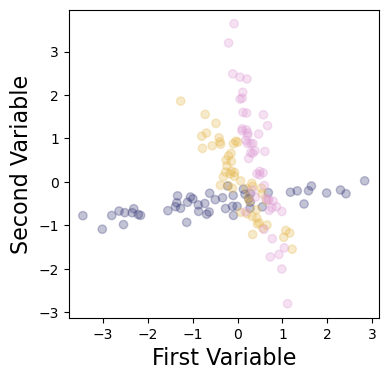

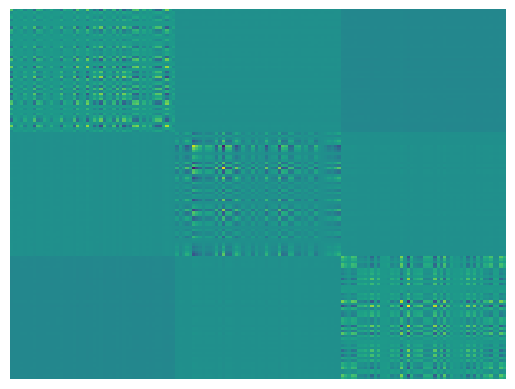

In [165]:
# Plot clusters
plt.figure(figsize=(4,4))
plt.scatter(X_c[:,plot_idxs[0]],X_c[:,plot_idxs[1]], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha)
# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

# Plot PCA approximation with num_components components
#X_pcas = list()
#for ncl in range(num_clusters):
#    idx = np.where(true_clusters==ncl)[0]
#    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
#    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
   # plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

# Plot Covariance
plt.figure()
C = np.dot(X_c,X_c.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')


### Run PCMF Full

In [166]:
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,8,250))[::-1]),axis=0)


In [167]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 
nn = 15

# Fit full model
A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)

# Fit partial u,V model
V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)
Apals_list = []
spals_list = []
for p in range(len(penalty_list)):
    spals_list.append(u_list_approx_uV[p].T@X_c@V_list_approx_uV[p].T)
    x_pcmf = []
    for i in range(X_c.shape[0]):
        x_pcmf.append(np.dot(np.dot(u_list_approx_uV[p][i,:],spals_list[p][:,i]),V_list_approx_uV[p][i,:]))
    Apals_list.append(x_pcmf)



weights: Gaussian neighbors: 15 gauss_coef: 2.0 rho: 1.2
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 2.98096e+03...[ 12 ] 2.77307e+03...[ 13 ] 2.57968e+03...[ 14 ] 2.39978e+03...[ 15 ] 2.23242e+03...[ 16 ] 2.07674e+03...[ 17 ] 1.93191e+03...[ 18 ] 1.79718e+03...[ 19 ] 1.67185e+03...[ 20 ] 1.55526e+03...[ 21 ] 1.44680e+03...[ 22 ] 1.34590e+03...[ 23 ] 1.25204e+03...[ 24 ] 1.16473e+03...[ 25 ] 1.08350e+03...[ 26 ] 1.00794e+03...[ 27 ] 9.37647e+02...[ 28 ] 8.72257e+02...[ 29 ] 8.11428e+02...[ 30 ] 7.54840e+02...[ 31 ] 7.02199e+02...[ 32 ] 6.53229e+02...[ 33 ] 6.07674e+02...[ 34 ] 5.65296e+02...[ 35 ] 5.25873e+02...[ 36 ] 4.89200e+02...[ 37 ] 4.55084e+02...[ 38 ] 4.23347e+02...[ 39 ] 3.93824e+02...[ 40 ] 3.66359e+02...[ 41 ] 3.40810e+02...[ 42 ] 3.17043e+02...[ 43 ] 2.94933e+02...[ 44 ] 2.74365e+02...[ 45 ] 2.55231e+02...[ 46 ] 2.37432e+02...[ 47 ] 2.20874e+02...[ 48 ] 2.05470e+02...[ 49 ] 1.91141e+02...[ 5

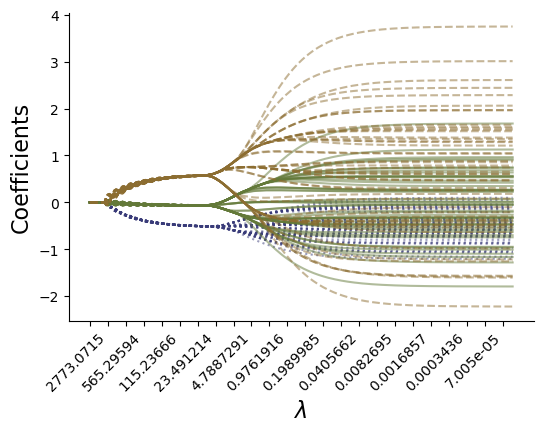

In [168]:
# Plot paths
import matplotlib
import seaborn as sns
path_plot(np.asarray(A_list)[:,:,21:22], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4))
          #xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)

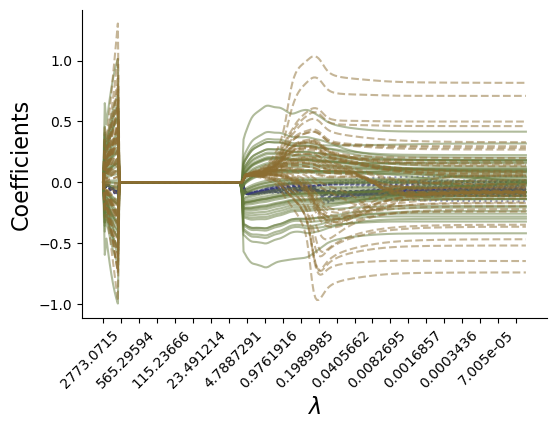

In [169]:
# Plot paths
import matplotlib
import seaborn as sns
path_plot(np.asarray(Apals_list)[:,:,21:22], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4))
          #xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)

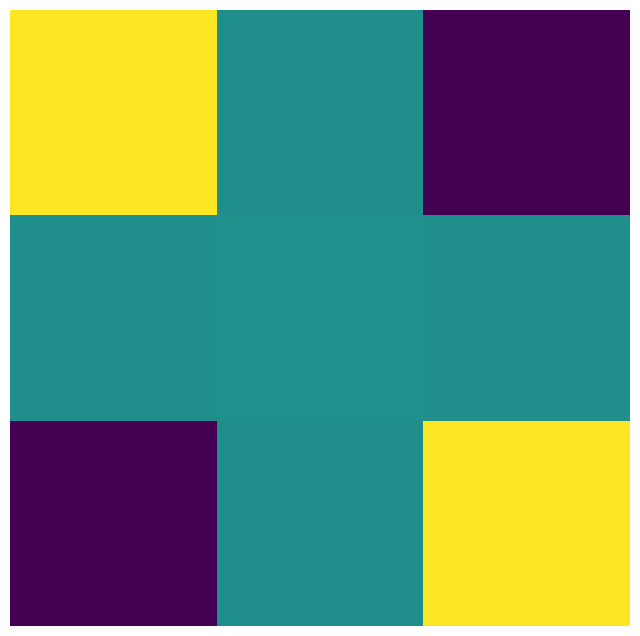

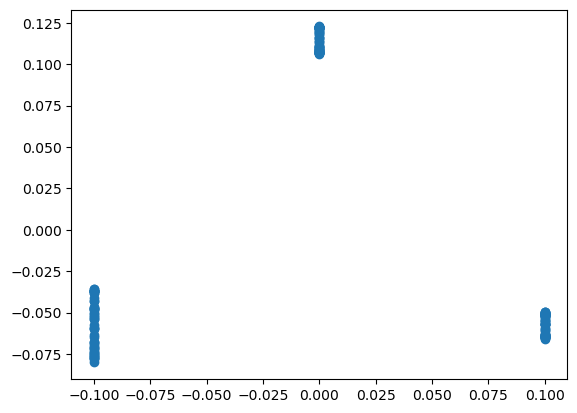

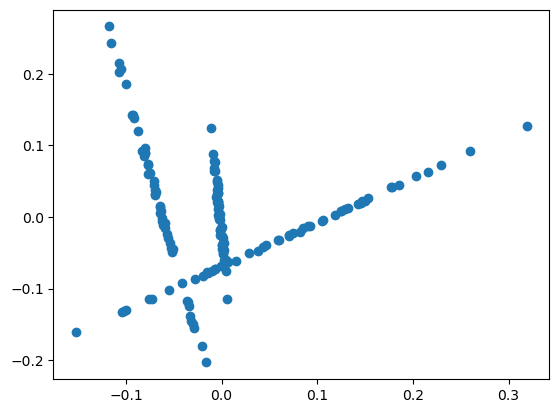

In [180]:
# Plot Covariance

A = A_list[50]

plt.figure(figsize=(8,8))
C = np.dot(A,A.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')

U,d,Vh = np.linalg.svd(C)
plt.figure()
plt.scatter(U[:,0],U[:,1])

U,d,Vh = np.linalg.svd(np.dot(X_c,X_c.T))
plt.figure()
plt.scatter(U[:,0],U[:,1])


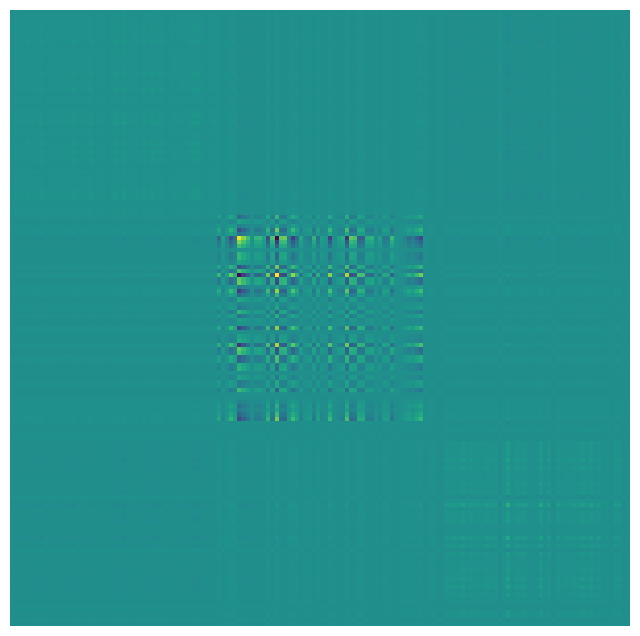

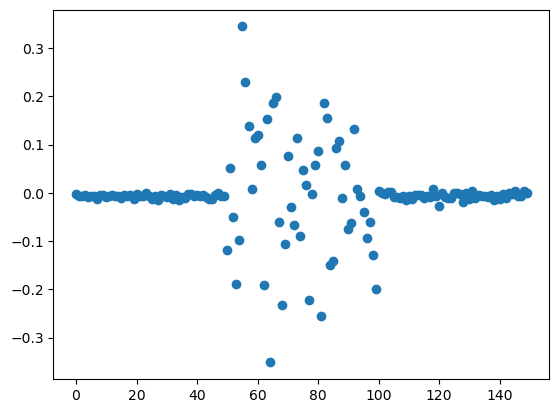

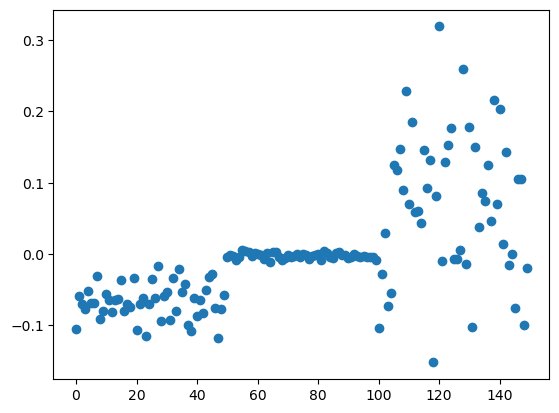

In [178]:
# Plot Covariance

A = np.asarray(Apals_list[115])

plt.figure(figsize=(8,8))
C = np.dot(A,A.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')

U,d,Vh = np.linalg.svd(C)
plt.figure()
plt.scatter(range(U.shape[0]),U[:,0])

U,d,Vh = np.linalg.svd(np.dot(X_c,X_c.T))
plt.figure()
plt.scatter(range(U.shape[0]),U[:,0])


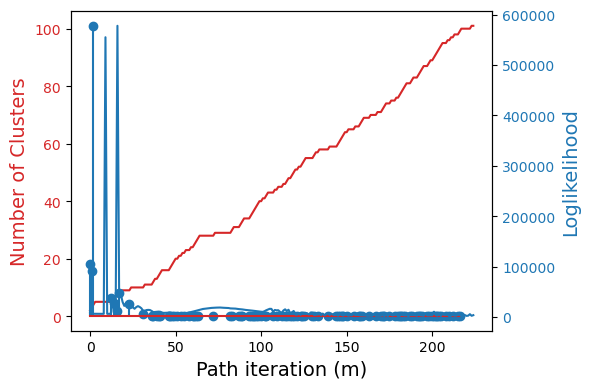

In [82]:
from pcmf import cluster_path

n_clusts, ics, centroids = cluster_path(X_c, A_list[35:], penalty_list[35:], gauss_coef=gc, neighbors=nn, selection='lik')

t = range(len(ics))
data1 = n_clusts
data2 = ics

clust_change_idx = np.where(np.diff(n_clusts)==1)[0] 
N = X_c.shape[0]
Ts = []
for i in range(len(clust_change_idx)-1):
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list_noinf = penalty_list[notinf_idx]
    lambda_t = penalty_list_noinf[clust_change_idx[i]]
    lambda_t_next = penalty_list_noinf[clust_change_idx[i+1]]
    Ts.append(N*lambda_t*(lambda_t - lambda_t_next))

fig, ax1 = plt.subplots(figsize=(6,4))

color = 'tab:red'
ax1.set_xlabel('Path iteration (m)',fontsize=14)
ax1.set_ylabel('Number of Clusters', color=color,fontsize=14)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.stem(clust_change_idx[:-1], np.max(data1)*(Ts/np.max(Ts))) #, use_line_collection=True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loglikelihood', color=color,fontsize=14)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [83]:
from scipy.stats import mode
mode(np.array(n_clusts)[np.where(np.array(n_clusts)>1)[0]])


ModeResult(mode=5, count=10)

In [84]:
N = X_c.shape[0]
    
def select_nclust(n_clust_list, penalty_list, N, method='cor_stat'):
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list = penalty_list[notinf_idx]
    clust_change_idx = np.where(np.diff(n_clust_list)==1)[0]+1
    Ts = []
    clust_nums = np.array(n_clusts)[clust_change_idx[:-1]+1]
    for i in range(len(clust_change_idx)-1):
        lambda_t = penalty_list[clust_change_idx[i]]
        lambda_t_next = penalty_list[clust_change_idx[i+1]]
        #print(N*lambda_t*(lambda_t - lambda_t_next), clust_nums[i])
        Ts.append(N*lambda_t*(lambda_t - lambda_t_next))
    if len(Ts) > 0 and method == 'cor_stat':
        print("Using correlation statistic for selection...")
        return clust_nums[np.where(np.array(Ts)==np.max(np.nan_to_num(np.array(Ts),posinf=0.0)))[0]]
    else:
        print("Using modal path value for selection...")
        from scipy.stats import mode
        return mode(np.array(n_clust_list)[np.where(np.array(n_clust_list)>1)[0]])[0]


Using correlation statistic for selection...
[5]


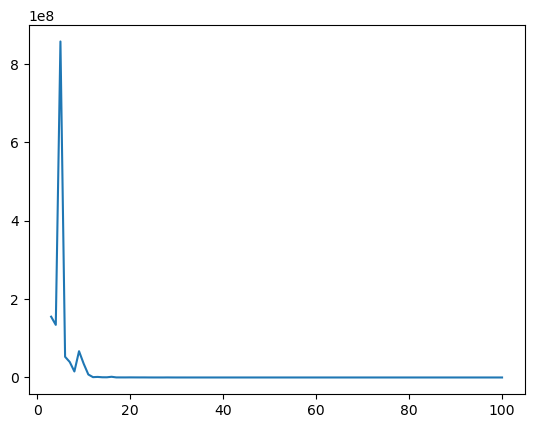

In [85]:
plt.plot(np.array(range(len(Ts)))+n_clusts[0]+1, np.array(Ts))
selected = select_nclust(n_clusts, penalty_list, X_c.shape[0])
print(selected)

In [86]:
selected = select_nclust(n_clusts, penalty_list, X_c.shape[0], method='mode'); n_clusts[0]
print(selected)


Using modal path value for selection...
5


In [30]:
def fit_elasticnetsubspace(X, n_clusters):
    '''Elastic net clustering'''
    from cluster.selfrepresentation import ElasticNetSubspaceClustering
    data_in = X
    essc = ElasticNetSubspaceClustering(n_clusters=n_clusters, algorithm='spams', gamma=5, active_support=False, tau=0.1).fit(data_in)
    labels = essc.labels_
    return labels
    
def fit_ward(X, n_clusters):
    '''Ward clustering'''
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    data_in = X
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(data_in, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity).fit(data_in)
    labels = clustering.labels_    
    return labels #, ari, nmi, acc

def fit_spectral(X, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    data_in = X
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    return labels

def fit_dpgmm(X, n_clusters):
    '''DPGMM clustering'''
    from sklearn import mixture
    data_in = X
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', weight_concentration_prior_type='dirichlet_process',max_iter=1000)
    dpgmm_mod = dpgmm.fit(data_in)
    labels = dpgmm.predict(data_in)

    return labels
    

In [31]:
cd /Users/logang/Dropbox/GrosenickLab/Code/PCMF

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [32]:
from pcmf_deepcomparisons import fit_dec 


In [33]:
cd /Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master


/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master


In [87]:
import progressbar
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error
from pcmf import cluster_path

pcmf_num_clusts = []
pca_kmeans_si = []; pca_kmeans_ch = []; pca_kmeans_db = []
pca_spectral_si = []; pca_spectral_ch = []; pca_spectral_db = []
ward_si = []; ward_ch = []; ward_db = []
spectral_si = []; spectral_ch = []; spectral_db = []
elasticsubspace_si = []; elasticsubspace_ch = []; elasticsubspace_db = []
dec_si = []; dec_ch = []; dec_db = []

num_clusters = 5
nn = 15
for i in range(10):
    # Generate data
    np.random.seed(i)
    X_c, true_clusters, num_clusters = generate_data(num_clusters)
    
    print("Number of clusters:", num_clusters)
    num_components = num_clusters+1
    #D, comb_list = sparse_D(X_c.shape[0],X_c.shape[1])
    
    # # Fit full model
    # A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)
    # n_clusts, ics, centroids = cluster_path(X_c, A_list, penalty_list, gauss_coef=gc, neighbors=nn, selection='lik')
    # pcmf_num_clusts.append(select_nclust(n_clusts, penalty_list, X_c.shape[0]))
    # del A_list, U_list, s_list, V_list

    # Fit partial u,V model
    V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.5, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)
    Apals_list = []
    spals_list = []
    for p in range(len(penalty_list)):
        spals_list.append(u_list_approx_uV[p].T@X_c@V_list_approx_uV[p].T)
        x_pcmf = []
        for i in range(X_c.shape[0]):
            x_pcmf.append(np.dot(np.dot(u_list_approx_uV[p][i,:],spals_list[p][:,i]),V_list_approx_uV[p][i,:]))
        Apals_list.append(x_pcmf)
    n_clusts, ics, centroids = cluster_path(X_c, np.asarray(Apals_list), penalty_list, gauss_coef=gc, neighbors=nn, selection='lik', method='spectral')
    pcmf_num_clusts.append(select_nclust(n_clusts, penalty_list, X_c.shape[0]))
    del Apals_list, spals_list
    
    # # Fit Ward
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_ward(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # ward_si.append(np.where(si==np.max(si))[0] + 2)
    # ward_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # ward_db.append(np.where(db==np.max(db))[0] + 2)

    # # Fit Spectral
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_spectral(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # spectral_si.append(np.where(si==np.max(si))[0] + 2)
    # spectral_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # spectral_db.append(np.where(db==np.max(db))[0] + 2)
    
    # # Fit PCA-kmeans
    # u,d,vh = np.linalg.svd(X_c, full_matrices=False)
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     kmeans = KMeans(n_clusters=nc, random_state=0).fit(u[:,0:num_components])
    #     si.append(silhouette_score(X_c, kmeans.labels_))
    #     ch.append(calinski_harabasz_score(X_c, kmeans.labels_))
    #     db.append(davies_bouldin_score(X_c, kmeans.labels_))
    # pca_kmeans_si.append(np.where(si==np.max(si))[0] + 2)
    # pca_kmeans_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # pca_kmeans_db.append(np.where(db==np.max(db))[0] + 2)

    # # Fit PCA-spectral
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     spectral_clustering = SpectralClustering(n_clusters=nc, random_state=i, affinity="nearest_neighbors", assign_labels="cluster_qr").fit(u[:,0:num_components])
    #     si.append(silhouette_score(X_c, spectral_clustering.labels_))
    #     ch.append(calinski_harabasz_score(X_c, spectral_clustering.labels_))
    #     db.append(davies_bouldin_score(X_c, spectral_clustering.labels_))
    # pca_spectral_si.append(np.where(si==np.max(si))[0] + 2)
    # pca_spectral_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # pca_spectral_db.append(np.where(db==np.max(db))[0] + 2)
    
    # # Fit Elastic Subspace
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_elasticnetsubspace(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # elasticsubspace_si.append(np.where(si==np.max(si))[0] + 2)
    # elasticsubspace_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # elasticsubspace_db.append(np.where(db==np.max(db))[0] + 2)

    # # Fit DEC
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels, _, _ = fit_dec(X_c, true_clusters, batch_size_options=[15], finetune_iters_options=[10], layerwise_pretrain_iters_options=[10], cluster_iter_max_options=[10])
    #     labels = labels[0]
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # dec_si.append(np.where(si==np.max(si))[0] + 2)
    # dec_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # dec_db.append(np.where(db==np.max(db))[0] + 2)


Number of clusters: 5
weights: Gaussian neighbors: 15 gauss_coef: 2.0 rho: 1.5
[ 1 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 2 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 3 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 4 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 5 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 6 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 7 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 8 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 9 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 10 ] inf...PCMF subproblem is not defined for single cluster u, using PMD subproblem.
[ 11 ] 2.98096e+03...[ 12 ] 2.77307e+03...[ 13 ] 2

In [88]:
pcmf_num_clusts

[array([5]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([3]),
 array([2]),
 array([8]),
 array([2]),
 array([2])]

In [55]:
# Correct for occasional ragged array results from DEC output
for i in range(len(dec_si)):
    if dec_si[i].shape==():
        dec_si[i] = np.array([dec_si[i]])
    if dec_si[i].shape[0]>1:
        dec_si[i] = np.array([dec_si[i][0]])

    if dec_ch[i].shape==():
        dec_ch[i] = np.array([dec_ch[i]])
    if dec_ch[i].shape[0]>1:
        dec_ch[i] = np.array([dec_ch[i][0]])

    if dec_db[i].shape==():
        dec_db[i] = np.array([dec_db[i]])
    if dec_db[i].shape[0]>1:
        dec_db[i] = np.array([dec_db[i][0]])

np.mean(dec_ch)

nan

In [94]:
pcmf_num_clusts[5] = np.array([6])

In [95]:
print("PCMF:", np.mean(pcmf_num_clusts), np.std(pcmf_num_clusts))
print("PCA+Kmeans Silhouette:", np.mean(pca_kmeans_si), np.std(pca_kmeans_si))
print("PCA+Kmeans Calinski-Harabasz:", np.mean(pca_kmeans_ch), np.std(pca_kmeans_ch))
print("PCA+Kmeans Davies-Bouldin:", np.mean(pca_kmeans_db), np.std(pca_kmeans_db))
print("PCA+SC Silhouette:", np.mean(pca_spectral_si), np.std(pca_spectral_si))
print("PCA+SC Calinski-Harabasz:", np.mean(pca_spectral_ch), np.std(pca_spectral_ch))
print("PCA+SC Davies-Bouldin:", np.mean(pca_spectral_db), np.std(pca_spectral_db))
print("SC Silhouette:", np.mean(spectral_si), np.std(spectral_si))
print("SC Calinski-Harabasz:", np.mean(spectral_ch), np.std(spectral_ch))
print("SC Davies-Bouldin:", np.mean(spectral_db), np.std(spectral_db))
print("Elastic Subspace Silhouette:", np.mean(elasticsubspace_si), np.std(elasticsubspace_si))
print("Elastic Subspace Calinski-Harabasz:",  np.mean(elasticsubspace_ch), np.std(elasticsubspace_ch))
print("Elastic Subspace Davies-Bouldin:",  np.mean(elasticsubspace_db), np.std(elasticsubspace_db))
print("DEC Silhouette:", np.mean(dec_si), np.std(dec_si))
print("DEC Calinski-Harabasz:",  np.mean(dec_ch), np.std(dec_ch))
print("DEC Davies-Bouldin:",  np.mean(dec_db), np.std(dec_db))

PCMF: 3.9 2.071231517720798
PCA+Kmeans Silhouette: nan nan
PCA+Kmeans Calinski-Harabasz: nan nan
PCA+Kmeans Davies-Bouldin: nan nan
PCA+SC Silhouette: nan nan
PCA+SC Calinski-Harabasz: nan nan
PCA+SC Davies-Bouldin: nan nan
SC Silhouette: nan nan
SC Calinski-Harabasz: nan nan
SC Davies-Bouldin: nan nan
Elastic Subspace Silhouette: nan nan
Elastic Subspace Calinski-Harabasz: nan nan
Elastic Subspace Davies-Bouldin: nan nan
DEC Silhouette: nan nan
DEC Calinski-Harabasz: nan nan
DEC Davies-Bouldin: nan nan


### Run PCMF PALS

In [24]:
pwd

'/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master'

In [25]:
import sys
sys.path.append("./scikit-sparse/")

In [26]:
import sksparse as sps

In [16]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 

# Fit partial u,V model
V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.5, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 5, neighbors=15)


ModuleNotFoundError: No module named 'sksparse.cholmod'

In [61]:
networkx.__version__, scipy.__version__


('2.6.3', '1.9.3')

In [36]:
cluster_pcmfs_pals

[]

In [60]:
%load_ext autoreload

%autoreload 2

import importlib
import scipy
#import networkx #import the module here, so that it can be reloaded.
#importlib.reload(networkx)
importlib.reload(scipy)

Apals_list = []
spals_list = []
for p in range(len(penalty_list)):
    spals_list.append(u_list_approx_uV[p].T@X_c@V_list_approx_uV[p].T)
    x_pcmf = []
    for i in range(X_c.shape[0]):
        x_pcmf.append(np.dot(np.dot(u_list_approx_uV[p][i,:],spals_list[p][:,i]),V_list_approx_uV[p][i,:]))
    Apals_list.append(x_pcmf)

    
cluster_pcmfs_pals = []
for i in range(len(penalty_list)):
    cluster_pcmf_pals = diff_graph_cluster(np.array(Apals_list[i]), D, comb_list, num_clusters).astype(int)
    cluster_pcmfs_pals.append(cluster_pcmf_pals)
    

# cluster_pcmfs_pals_new = []
# for idx in range(0,len(cluster_pcmfs_pals)):
#     cluster_pcmfs_pals_new.append( cluster_matching(cluster_pcmfs_pals[idx], true_clusters ) )




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q8/v05ct80136s_vt_x7bq2dq780000gn/T/ipykernel_24320/1954471005.py", line 23, in <cell line: 22>
    cluster_pcmf_pals = diff_graph_cluster(np.array(Apals_list[i]), D, comb_list, num_clusters).astype(int)
  File "/var/folders/q8/v05ct80136s_vt_x7bq2dq780000gn/T/ipykernel_24320/3905139414.py", line 26, in diff_graph_cluster
    edges = np.sum(D*Xhat,axis=1)
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/cvxpy/interface/scipy_wrapper.py", line 31, in new_method
    return method(self, other)
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/scipy/sparse/base.py", line 464, in __mul__
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

Trac

### Plots / videos

#### Plot paths

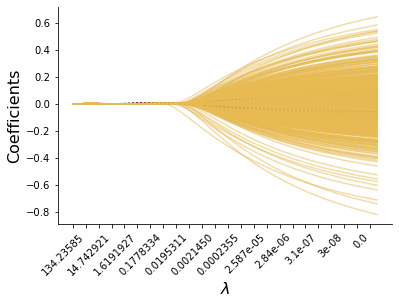

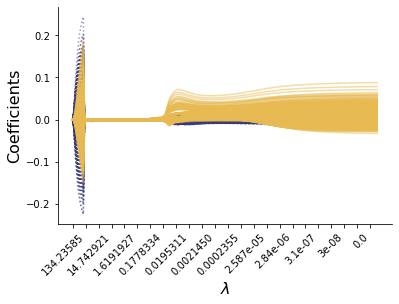

In [43]:
# Plot paths
import matplotlib
import seaborn as sns
path_plot(np.asarray(A_list)[:,:,21:22], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)


path_plot(np.asarray(Apals_list)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)

### Generate videos

In [44]:
print('video_prefix',video_prefix)

video_prefix movies/gaussian_twoclass_centered_


#### Video of PCMF full path + X scatter plot

First figure


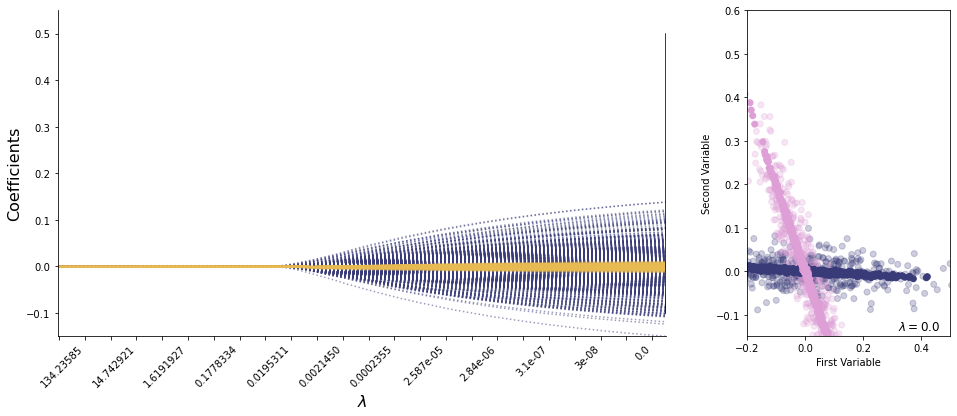

In [45]:
import seaborn as sns

# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(16,6))
l = plt.scatter([], [])

# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

with writer.saving(fig, video_prefix+"pcmf_full_"+"pathAndPlot.mp4", 300):
    for penalty_idx in range(len(penalty_list)):
        fig.clear()    
        ax = fig.add_subplot(gs[0], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        path_plot_video(np.asarray(A_list)[:,:,6:7], penalty_list, penalty_idx, fig, ax, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(12,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
        plt.ylim(-0.15, 0.55)
        
        ax = fig.add_subplot(gs[1], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = true_clusters #cluster_pcmfs_new[penalty_idx]
        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[penalty_idx,:,0],np.asarray(A_list)[penalty_idx,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
   
        writer.grab_frame()


#### Video of PCMF PALS path + X scatter plot

First figure


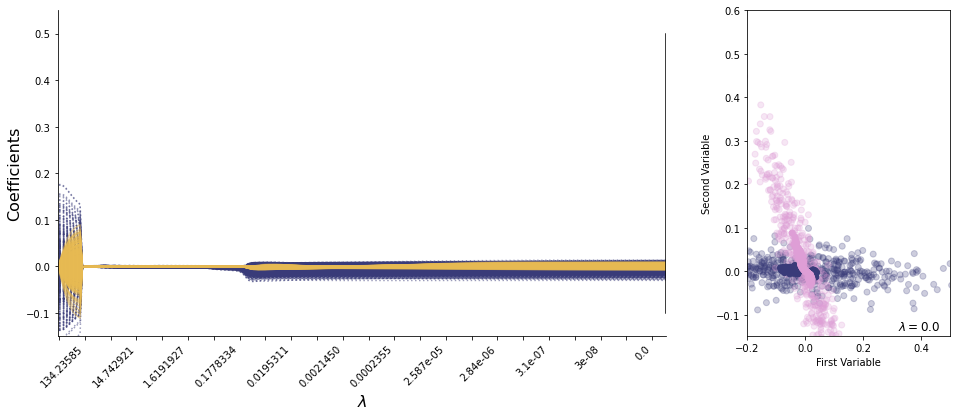

In [46]:
import seaborn as sns

# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(16,6))
l = plt.scatter([], [])

# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

with writer.saving(fig, video_prefix+"pcmf_pals_"+"pathAndPlot.mp4", 300):
    for penalty_idx in range(len(penalty_list)):
        fig.clear()    
        ax = fig.add_subplot(gs[0], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        path_plot_video(np.asarray(Apals_list)[:,:,6:7], penalty_list, penalty_idx, fig, ax, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(12,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
        plt.ylim(-0.15, 0.55)
        
        ax = fig.add_subplot(gs[1], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = true_clusters # cluster_pcmfs_pals_new[penalty_idx]
        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[penalty_idx,:,0],np.asarray(Apals_list)[penalty_idx,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
   
        writer.grab_frame()

#### PCMF Full X scatterplot video

First figure


NameError: name 'cluster_pcmfs_new' is not defined

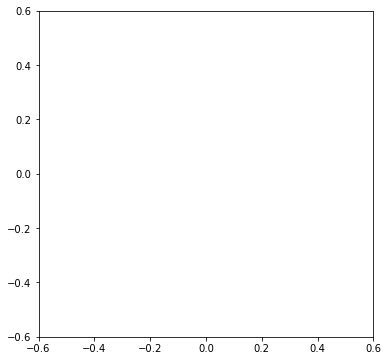

In [23]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


with writer.saving(fig, video_prefix+"pcmf_full_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))
#         cluster_pcmf = diff_graph_cluster(np.array(A_list[i]), D, comb_list, num_clusters).astype(int)
        cluster_pcmf = cluster_pcmfs_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        

#### PCMF PALS X scatter plot video

In [ ]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


with writer.saving(fig, video_prefix+"pcmf_pals_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_pals_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[i,:,0],np.asarray(Apals_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        

#### PCMF Full and PALS X scatter plot video

First figure


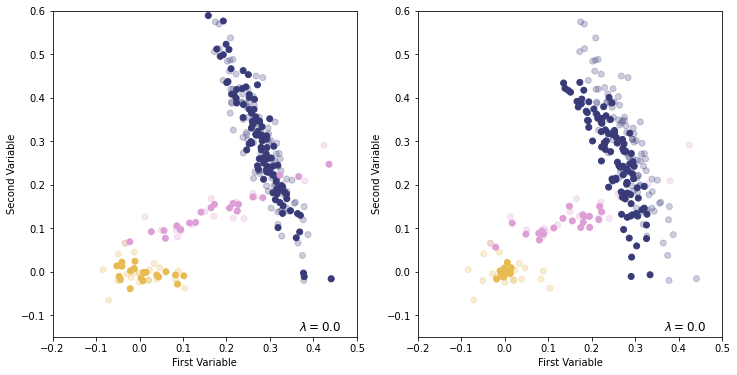

In [31]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(12,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

with writer.saving(fig, video_prefix+"pcmf_full-pals_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(121, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        
        ax = fig.add_subplot(122, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_pals_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[i,:,0],np.asarray(Apals_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        